### Slitless Spectroscopy Example - JWST NIRISS Grism

This notebook shows exposure level processing of JWST NIRISS Grism rate images. It focuses on explaining the new WCS tools made available for JWST which help processing grism data.

The assumption is that there one or more direct images were taken without moving the telescope and with the same instrument configuration as the grism images (same filter). This allows the distortion used models for the direct images to be included in the grism WCS pipeline. Essentially the direct image acts as a reference point in the WCS pipeline with its transform to sky applied in one part of the pipeline from sky to grism pixels and a transform from direct to grism image chained to it.

`sky` (RA, DEC, WAVE, ORDER) --> `direct_image` (IMX, IMY, WAVE, ORDER) --> `grism_image` (GRISMX, GRISMY) 

#### Reference files 

- The transform from `sky` to `direct_image` uses a reference file with distortion model.

- The transform from direct image to grism image is a polynomial which defines the spectral trace on the grism image. Include reference to Nor's paper.

- A reference file containing the wavelength range for every spectral order 

All files are in ASDF format.

#### Processing workflow

- The direct images (one or more dither observations) are processed through the Level 2 Imaging Pipeline and then the Level3 Imaging pipepine. 
- A source detection algorithm is run on the combined resampled image and a source catalog is produced. 
- The grism image is run through the Level 2 spectral pipeline using the source catalog produced by processing the direct images.
 - The assign_wcs step constructs a WCS pipeline which passes through the following coordinate frames
 
 `grism_image -> direct_image -> V3V3 -> sky`
 
            `specwcs`     `distortion`
                              

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import astropy
from astropy.io import fits

import numpy as np
import asdf
#pipeline
import jwst
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline
#wcs
from jwst import assign_wcs
from jwst.assign_wcs import assign_wcs_step
from jwst.assign_wcs import AssignWcsStep
from jwst.extract_2d import Extract2dStep
#datamodels
from jwst import datamodels

In [14]:
specwcs = "jwst_niriss_specwcs_0018.asdf"

distortion = "jwst_niriss_distortion_0013.asdf"

filteroffset = "jwst_niriss_filteroffset_0002.asdf"

wavelength_range = "jwst_niriss_wavelengthrange_0002.asdf"


In [24]:
aspecwcs = asdf.open(specwcs)
asdf.info(specwcs, max_rows=200, max_cols=200)

2022-09-05 18:11:17,896 - stpipe - WARNING - /var/folders/zd/pv7w8zxd3b9csmwxrwwg3gh80003pk/T/ipykernel_32909/2407714028.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='jwst_niriss_specwcs_0018.asdf'>
  aspecwcs = asdf.open(specwcs)



root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.11.1
├─history (dict)
│ ├─entries (list)
│ │ └─[0] (HistoryEntry)
│ │   ├─description (str): NIRISS Grism Parameters
│ │   ├─software (Software)
│ │   │ ├─author (str): Swara Ravindranath
│ │   │ ├─homepage (str): https://github.com/spacetelescope/jwreftools
│ │   │ ├─name (str): niriss_reftools.py
│ │   │ └─version (str): 0.7.1
│ │   └─time (datetime)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension.BuiltinExtension
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 2.11.1
│   ├─[1] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.5.0
│   │ └─software (Software)
│   │   ├─name (str): asdf-astropy
│   │   └─version 

In [27]:
asdf.info(distortion, max_rows=200, max_cols=200)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.3
├─history (dict)
│ ├─entries (list)
│ │ └─[0] (HistoryEntry)
│ │   ├─description (str): This file is being delivered because it is the wcs reference and distortion correction reference file. Documentation and scripts can be found in  (truncated)
│ │   └─time (datetime)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension.BuiltinExtension
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 2.8.3
│   ├─[1] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://asdf-format.org/transform/extensions/transform-1.5.0
│   │ └─software (Software)
│   │   ├─name (str): asdf-astropy
│   │   └─version (str): 0.1.2
│   └─[2] (ExtensionMetadata)
│     ├─extension_class (str)

In [31]:
asdf.info(wavelength_range, max_rows=500, max_cols=500)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): Space Telescope Science Institute
│ ├─homepage (str): http://github.com/spacetelescope/asdf
│ ├─name (str): asdf
│ └─version (str): 2.1.0.dev1417
├─history (dict)
│ ├─entries (list)
│ │ └─[0] (HistoryEntry)
│ │   ├─description (str): Ground NIRCAM wavelength ranges, updated to include specific extraction orders per filter and a clearer structure for the wavelengthrange property
│ │   ├─software (Software)
│ │   │ ├─author (str): STScI
│ │   │ ├─homepage (str): https://github.com/spacetelescope/jwreftools
│ │   │ ├─name (str): niriss_reftools.py
│ │   │ └─version (str): 0.7.1
│ │   └─time (datetime)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension.BuiltinExtension
│   │ └─software (dict)
│   │   ├─name (str): asdf
│   │   └─version (str): 2.1.0.dev1417
│   └─[1] (ExtensionMetadata)
│     ├─extension_class (str): astropy.io.misc.asdf.extension.AstropyAsdfExtension
│     └─softwa

##### Run Level2 and Level 3 of the Imaging Pipeline

In [5]:
fimage = 'jw01448013001_02106_00001_nis_rate.fits'
outim2 = Image2Pipeline.call(fimage)

2022-09-05 18:04:13,533 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /Users/dencheva/crds/references/jwst/niriss/jwst_niriss_pars-image2pipeline_0002.asdf
2022-09-05 18:04:13,554 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-09-05 18:04:13,556 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-09-05 18:04:13,558 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-09-05 18:04:13,560 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-09-05 18:04:13,561 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2022-09-05 18:04:13,563 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2022-09-05 18:04:13,642 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('jw01448013001_02106_00001_nis_rate.fits',).
2022-09-05 18:04:13,651 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [],

2022-09-05 18:04:15,145 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-09-05 18:04:15,231 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from jw01448013001_02106_00001_nis_rate.fits>,).
2022-09-05 18:04:15,233 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-09-05 18:04:15,276 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /Users/dencheva/crds/references/jwst/niriss/jwst_niriss_photom_0035.fits
2022-09-05 18:04:15,277 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /Users/dencheva/crds/references/jwst/niriss/jwst_niriss_area_0017.fits
2022-09-05 18:04:15,385 - stpipe

In [6]:
Image3Pipeline.from_cmdline(["calwebb_image3", "jw01448013001_02106_00001_nis_cal.fits"])

2022-09-05 18:04:31,980 - stpipe - INFO - PARS-TWEAKREGSTEP parameters found: /Users/dencheva/crds/references/jwst/niriss/jwst_niriss_pars-tweakregstep_0001.asdf
2022-09-05 18:04:31,996 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/dencheva/crds/references/jwst/niriss/jwst_niriss_pars-outlierdetectionstep_0002.asdf
2022-09-05 18:04:32,019 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   No match found.
2022-09-05 18:04:32,034 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-09-05 18:04:32,035 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-09-05 18:04:32,037 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2022-09-05 18:04:32,039 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2022-09-05 18:04:32,040 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-09-05 18:04:32,042 - stpipe.

2022-09-05 18:04:44,872 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(2063, 2040) from jw01448013001_02106_00001_nis_i2d.fits>,).
2022-09-05 18:04:44,874 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 1000, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 25, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}
2022-09-05 18:04:44,905 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file: /Users/dencheva/crds/references/jwst/niriss/jwst_niriss_apcorr_0005.fits
2022-09-05 18:04:44,919 - stpipe.Image3Pipeline.source_catalog - INFO - U

Level 3 processing produces a catalog - jw01448013001_02106_00001_nis_cat.ecsv.

The output image from L3 pipeline is jw01448013001_02106_00001_nis_i2d.fits.

##### Run the assign_wcs step on the spectral image. It uses the reference files to chain all transforms and generate a WCS pipeline

In [7]:
# Process one grism observation using the new reference file
#specwcs = "jwst_niriss_specwcs_0012.asdf"
fname = "jw01448013001_02105_00001_nis_rate.fits"
astep = AssignWcsStep()
out = astep.call(fname)

2022-09-05 18:06:23,599 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-09-05 18:06:23,876 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-09-05 18:06:23,971 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('jw01448013001_02105_00001_nis_rate.fits',).
2022-09-05 18:06:23,973 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-09-05 18:06:25,414 - stpipe.AssignWcsStep - INFO - Added Barycentric velocity correction: 0.999965786033709
2022-09-05 18:06:25,789 - stpipe.AssignWcsStep

##### Extract_2d

Run the extract_2d step in the pipeline. It uses the source catalog and the WCS object to find the location of the trace for each slit and order and extract a cutout with the corresponding WCS. The limits of the cutpout are defined from the segmentation map of the image on the sky. The corners on the sky are transformed to the grism detector using the inverse WCS transform.

In [8]:
out.meta.source_catalog="jw01448013001_02106_00001_nis_cat.ecsv"
exout = Extract2dStep.call(out, wfss_mmag_extract=21)
exout.save("jw01448013001_02105_00001_nis_ex2d.fits")

2022-09-05 18:06:42,059 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.
2022-09-05 18:06:42,148 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(2048, 2048) from jw01448013001_02105_00001_nis_rate.fits>,).
2022-09-05 18:06:42,150 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': 21, 'wfss_nbright': 1000}
2022-09-05 18:06:42,175 - stpipe.Extract2dStep - INFO - EXP_TYPE is NIS_WFSS
2022-09-05 18:06:42,202 - stpipe.Extract2dStep - INFO - Extracting objects < abmag = 21
2022-09-05 18:06:42,203 - stpipe.Extract2dStep - INFO - Getti

2022-09-05 18:06:51,439 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 439 order: 1:
2022-09-05 18:06:51,440 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1223.0825997333832, xmax:1233.0825997333832), (ymin:1201, ymax:1374)
2022-09-05 18:06:51,564 - stpipe.Extract2dStep - INFO - YYY, (1695, 1854), 1695
2022-09-05 18:06:51,776 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 612 order: 1:
2022-09-05 18:06:51,776 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:748, xmax:794), (ymin:1695, ymax:1854)
2022-09-05 18:06:52,071 - stpipe.Extract2dStep - INFO - YYY, (1469, 1623), 1469
2022-09-05 18:06:52,281 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 540 order: 1:
2022-09-05 18:06:52,281 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1292.8053466456336, xmax:1302.8053466456336), (ymin:1469, ymax:1623)
2022-09-05 18:06:52,407 - stpipe.Extract2dStep - INFO - YYY, (323, 481), 323
2022-09-05 18:06:52,619 - stpipe.Extract

'jw01448013001_02105_00001_nis_ex2d.fits'

##### Plots

Plot the grism image with the bounding_boxes (cutouts) of the individual slits and the location of the sources.

<IPython.core.display.Javascript object>


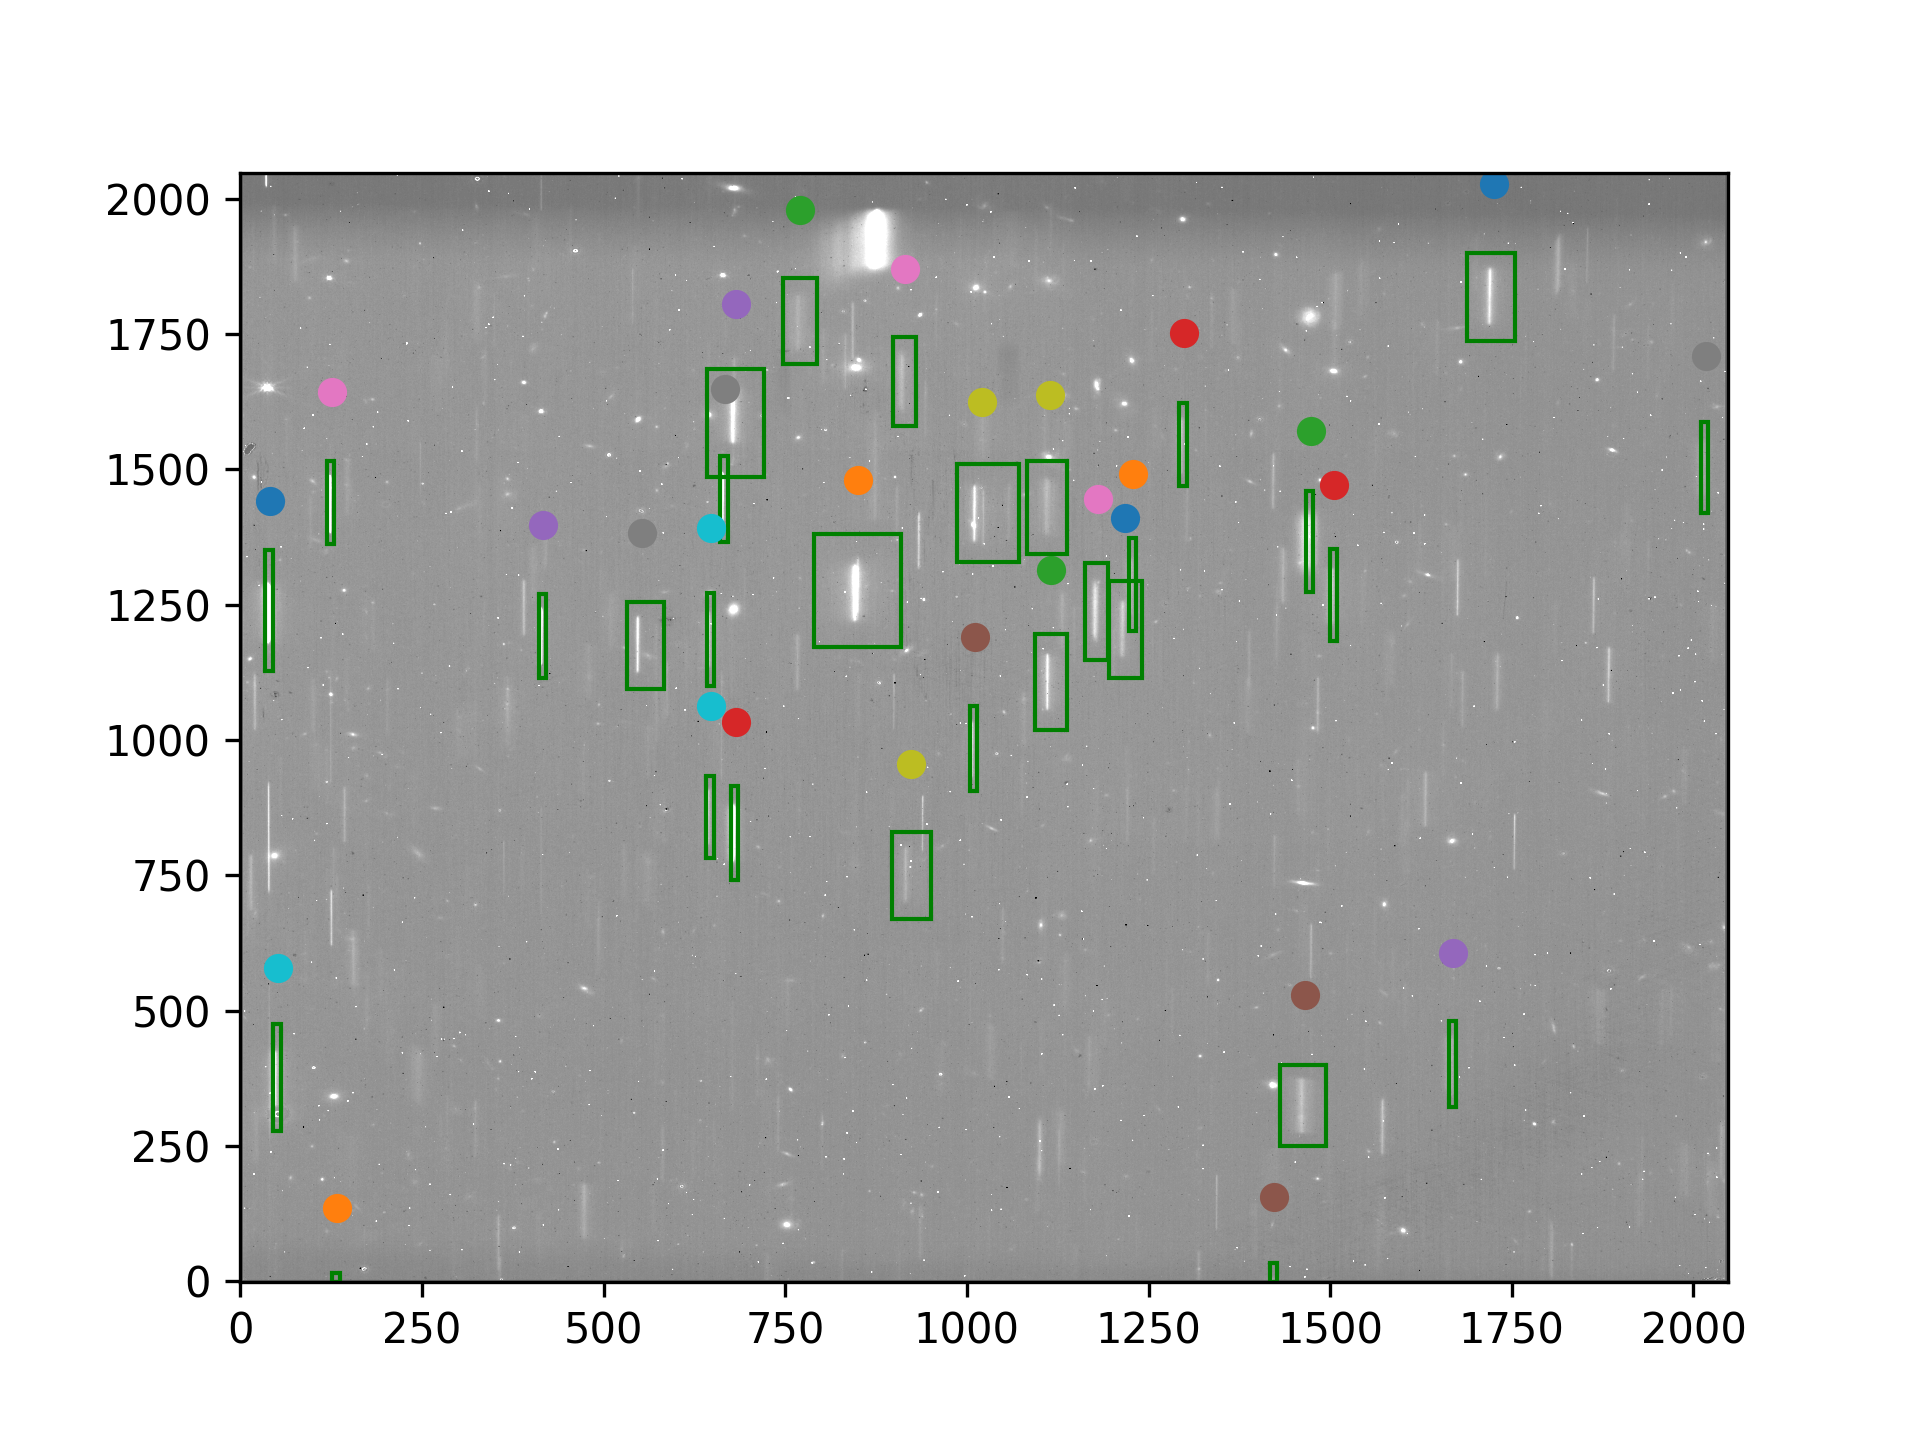

In [32]:
ax = plt.subplot()
ax.imshow(out.data, aspect='auto', vmin=-1, vmax=1.4, origin='lower')
plt.gray()

for slit in exout.slits:
    ax.scatter(slit.source_xpos, slit.source_ypos)
    bbox = slit.meta.wcs.bounding_box
    xstart, ystart = slit.xstart, slit.ystart
    ax.add_patch(patches.Rectangle((bbox[0][0]+xstart-1, bbox[1][0]+ystart-1), 
                                   bbox[0][1]-bbox[0][0], bbox[1][1]-bbox[1][0], edgecolor='g',
                                   fill=False))

plt.gray()